<a href="https://colab.research.google.com/github/ASIF-Mahmud1/Exploration/blob/text-classifier/NLP_Lessons/BERT/EnronDatasetDiminsihingTerms_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install torchvision
!pip install torchvision


In [ ]:
import torch

In [ ]:
from typing import Callable, List, Optional, Tuple

import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch


class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(text,
                                                    add_special_tokens=True,
                                                    max_length=self.max_length
                                                    )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [ ]:
!pip install transformers


     |████████████████████████████████| 2.0MB 12.5MB/s 
     |████████████████████████████████| 870kB 48.1MB/s 
     |████████████████████████████████| 3.3MB 39.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=4dc43642e459cc326ad6c5cfe156cf78b4ea8e28c08cfc2d4039b572d30b6dd0
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
from transformers import BertTokenizer, BertModel
import torch
bert_model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


In [ ]:
bert_transformer = BertTransformer(tokenizer, bert_model)
from sklearn.pipeline import Pipeline


In [ ]:
url="https://raw.githubusercontent.com/ASIF-Mahmud1/Exploration/text-classifier/DiminishingTerms/dataSet.csv"
from io import StringIO
import string
import pandas as pd
import requests
s=requests.get(url).text

message_data=pd.read_csv(StringIO(s))
message_data['tag'] = message_data['tag'].str.strip()

message_data.head()
message_data['tag'].describe()

count             315
unique              2
top       diminishing
freq              234
Name: tag, dtype: object

In [ ]:
message_data_copy = message_data['sentence'].copy() 

# message_data_copy

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=5.2)


In [ ]:
pipeline = Pipeline(steps=  [
        ("vectorizer", bert_transformer),
        ("classifier", classifier),
    ] )

pipeline.fit(message_data_copy,  message_data['tag'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_pa

Pipeline(memory=None,
         steps=[('vectorizer',
                 BertTransformer(bert_model=None, bert_tokenizer=None,
                                 embedding_func=<function BertTransformer.__init__.<locals>.<lambda> at 0x7f25d6f56b00>,
                                 max_length=60)),
                ('classifier',
                 LogisticRegression(C=5.2, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='multinomial', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
import pandas as pd
df = pd.read_csv('https://query.data.world/s/yqgskd2yg2lztwtgmpeajy75msskd6',error_bad_lines=False, index_col=False, dtype='unicode')
df = df.applymap(str) ## stringify all fields
df['content']

0                                      Here is our forecast
1         Traveling to have a business meeting takes the...
2                             test successful. way to go!!!
3         Randy, Can you send me a schedule of the salar...
4                         Let's shoot for Tuesday at 11:45.
                                ...                        
517396    This is a trade with OIL-SPEC-HEDGE-NG (John L...
517397    Some of my position is with the Alberta Term b...
517398    2 -----Original Message----- From: Doucet, Daw...
517399    Analyst Rank Stephane Brodeur 1 Chad Clark 1 I...
517400    i think the YMCA has a class that is for peopl...
Name: content, Length: 517401, dtype: object

In [ ]:
collectionSize=10
startIndex=0
endIndex=startIndex + collectionSize

# Test Sentences Here
### **Note**: Click Play to Predict next 10 emails

0  Here is our forecast
1  Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip without any formal business meetings. I would even try and get some honest opinions on whether a trip is even desired or necessary. As far as the business meetings, I think it would be more productive to try and stimulate discussions across the different groups about what is working and what is not. Too often the presenter speaks and the others are quiet just waiting for their turn. The meetings might be better if held in a round table discussion format. My suggestion for where to go is Austin. Play golf and rent a ski boat and jet ski's. Flying somewhere takes too much time.
2  test successful. way to go!!!
3  Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for

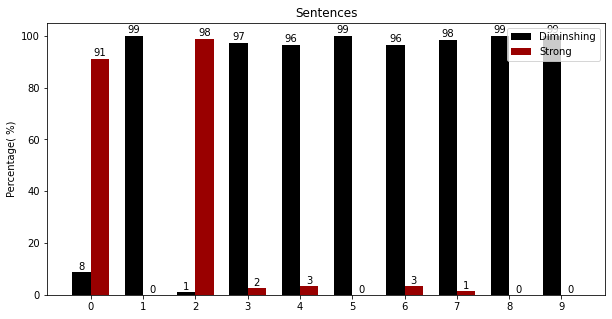

In [ ]:
# text = ["Do it now","I am want this now" , "I will try to solve this","I will solve this"]
text= df['content']
text= text[startIndex:endIndex]
# predict the label using the pipeline
for row in text.index:
    print(row, " "+text[row])

####################################################################################################################
                       ## Remove this later
prob_Of_Each_Class = pipeline.predict_proba(text)
import numpy as np
X = np.arange(startIndex,endIndex)
y_strong= prob_Of_Each_Class[:,1]*100
y_diminishing=prob_Of_Each_Class[:,0]*100    

"""
========
Barchart
========
A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = len(X)
men_means = y_diminishing

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(ind, men_means, width, color='black')

women_means = y_strong

rects2 = ax.bar(ind + width, women_means, width, color='#990000')
# add some text for labels, title and axes ticks
ax.set_ylabel('Percentage( %)')
ax.set_title('Sentences')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(X)

ax.legend((rects1[0], rects2[0]), ('Diminshing', 'Strong'))

def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.005*height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()
startIndex= startIndex+collectionSize
endIndex=startIndex+collectionSize
                       ## Remove this later
####################################################################################################################